In [16]:
# !pip install scikit_learn==1.3.2

In [3]:
# !pip install --upgrade pip

In [4]:
# !pip install --upgrade setuptools

Run 1: Parameters - {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Mean Squared Error: 4958.897698875
Run 2: Parameters - {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mean Squared Error: 4532.080767499994
Run 3: Parameters - {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Mean Squared Error: 4212.955259052937
Run 4: Parameters - {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mean Squared Error: 4155.0593191019525
Run 5: Parameters - {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Mean Squared Error: 4815.406942467144
Run 6: Parameters - {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Mean Squared Error: 4580.851219504142
Run 7: Parameters - {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
Mean Squared Error: 

Mean Squared Error: 5281.11974537831
Run 59: Parameters - {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150}
Mean Squared Error: 5147.476162230494
Run 60: Parameters - {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Mean Squared Error: 5226.581197703378
Run 61: Parameters - {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 50}
Mean Squared Error: 6599.657318129093
Run 62: Parameters - {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 100}
Mean Squared Error: 6488.60497473626
Run 63: Parameters - {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 150}
Mean Squared Error: 6185.316237165609
Run 64: Parameters - {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 200}
Mean Squared Error: 6369.812340336011
Run 65: Parameters - {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_

Mean Squared Error: 3746.0279520952217
Run 116: Parameters - {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Mean Squared Error: 3869.167955663071
Run 117: Parameters - {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Mean Squared Error: 4824.16657322874
Run 118: Parameters - {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Mean Squared Error: 4252.761499329753
Run 119: Parameters - {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}
Mean Squared Error: 3920.4579751994415
Run 120: Parameters - {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Mean Squared Error: 3911.798501024753
Run 121: Parameters - {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Mean Squared Error: 5471.804208205866
Run 122: Parameters - {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10

Mean Squared Error: 4811.574139443526
Run 173: Parameters - {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 50}
Mean Squared Error: 6221.157701471171
Run 174: Parameters - {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 100}
Mean Squared Error: 6111.003002792548
Run 175: Parameters - {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 150}
Mean Squared Error: 5821.987480606095
Run 176: Parameters - {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 200}
Mean Squared Error: 5890.560187666562
Run 177: Parameters - {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Mean Squared Error: 4578.604990365788
Run 178: Parameters - {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Mean Squared Error: 4333.427072103623
Run 179: Parameters - {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 

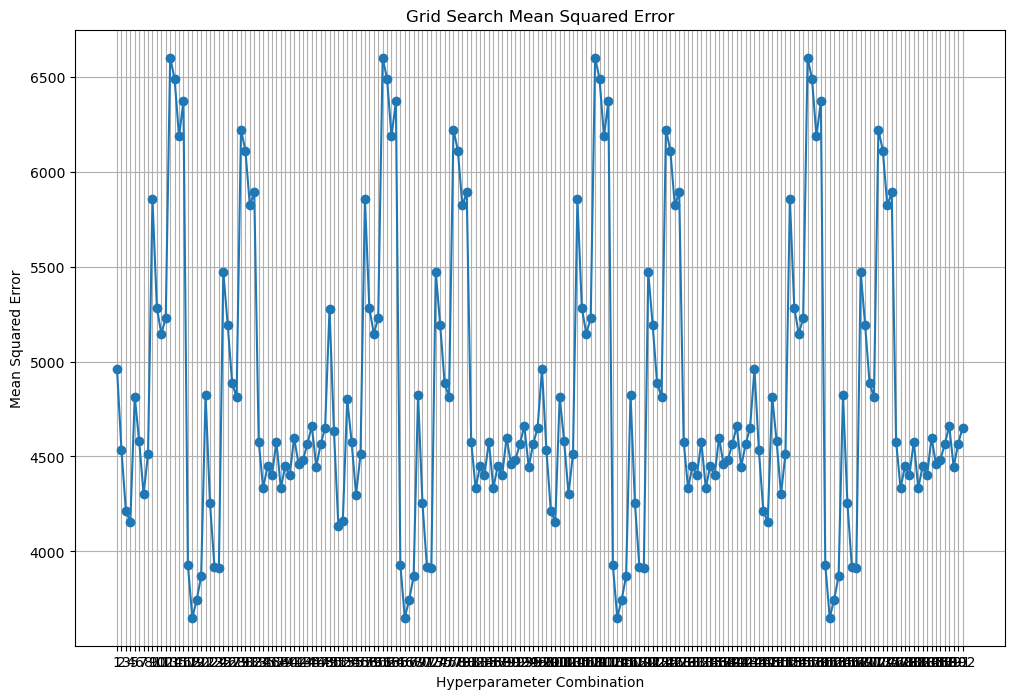

Best Model Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best Mean Squared Error: 3650.853491723248


In [17]:
from flask import Flask, render_template, request, jsonify
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv("fish.csv")

# Preprocess the dataset
X = data.drop(columns=['Species', 'Weight'])
y = data['Weight']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4]
}

# Create parameter grid
grid = ParameterGrid(param_grid)

# Initialize an empty list to store the mean metrics
mean_metrics = []

# Initialize variables to store the best model and its parameters
best_model = None
best_params = None
best_mse = float('inf')  # Initialize with a large value

# Perform grid search and print the combination being trained along with the mean metric
for i, params in enumerate(grid):
    print(f"Run {i + 1}: Parameters - {params}")

    # Train a RandomForestRegressor model with current hyperparameters
    model = RandomForestRegressor(**params, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mean_metrics.append(mse)
    print(f"Mean Squared Error: {mse}")

    # Check if this model is the best so far
    if mse < best_mse:
        best_mse = mse
        best_model = model
        best_params = params

# Plot RMSE over the grid
plt.figure(figsize=(12, 8))
plt.plot(mean_metrics, marker='o')
plt.xlabel('Hyperparameter Combination')
plt.ylabel('Mean Squared Error')
plt.title('Grid Search Mean Squared Error')
plt.xticks(ticks=range(len(mean_metrics)), labels=range(1, len(mean_metrics) + 1))
plt.grid(True)
plt.show()

# Save the best trained model
joblib.dump(best_model, "fish_weight_prediction_model.pkl")
print("Best Model Parameters:", best_params)
print("Best Mean Squared Error:", best_mse)
